In [19]:
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
#Download the training data and load it
# Use standard FashionMNIST dataset
testset = datasets.FashionMNIST('MNIST_data/', download=True, train=False, transform=transform)  
trainset = datasets.FashionMNIST('MNIST_data/', download=True, train=True, transform=transform)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [20]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.cf1 = nn.Linear(784, 256)
        self.cf2 = nn.Linear(256, 128)
        self.cf3 = nn.Linear(128, 64)
        self.cf4 = nn.Linear(64, 10)
        # dropout with the prob of 0.2
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        #flatten inputs
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.relu(self.cf1(x)))
        x = self.dropout(F.relu(self.cf2(x)))
        x = self.dropout(F.relu(self.cf3(x)))
        
        # output so no drop out hehe
        x = F.log_softmax(self.cf4(x), dim=1)
        
        return x

In [21]:
model = Classifier()
criterion = nn.NLLLoss()
optimization = optim.Adam(model.parameters(), lr=0.003)

In [22]:
# Training my network
epoches = 30
steps = 0
train_losses, test_losses = [],[]
for e in range(epoches):
    runing_loss = 0
    for images, labels in trainloader: 
        # Todo training pass
        optimization.zero_grad()
        
         #flatten images
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        #output = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        
        optimization.step()
        
        runing_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in testloader:
                images = images.view(images.shape[0], -1)
                log_ps = model(images)
                #log_ps = model.forward(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(runing_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        #print("training loss: ", runing_loss / len(trainloader))
        print("Epoche: {}/{}".format(e+1, epoches),
              "Train loss {:.3f}.. ".format(runing_loss/len(trainloader)),
              "Validation loss {:.3f}.. ".format(test_loss/len(testloader)),
              "Accuracy {:.3f}.. ".format(accuracy/len(testloader)))


Epoche: 1/30 Train loss 0.609..  Validation loss 0.474..  Accuracy 0.835.. 
Epoche: 2/30 Train loss 0.486..  Validation loss 0.457..  Accuracy 0.841.. 
Epoche: 3/30 Train loss 0.451..  Validation loss 0.462..  Accuracy 0.836.. 
Epoche: 4/30 Train loss 0.432..  Validation loss 0.418..  Accuracy 0.852.. 
Epoche: 5/30 Train loss 0.426..  Validation loss 0.412..  Accuracy 0.859.. 
Epoche: 6/30 Train loss 0.415..  Validation loss 0.405..  Accuracy 0.860.. 
Epoche: 7/30 Train loss 0.399..  Validation loss 0.374..  Accuracy 0.868.. 
Epoche: 8/30 Train loss 0.397..  Validation loss 0.367..  Accuracy 0.868.. 
Epoche: 9/30 Train loss 0.394..  Validation loss 0.379..  Accuracy 0.867.. 
Epoche: 10/30 Train loss 0.390..  Validation loss 0.378..  Accuracy 0.869.. 
Epoche: 11/30 Train loss 0.389..  Validation loss 0.372..  Accuracy 0.868.. 
Epoche: 12/30 Train loss 0.380..  Validation loss 0.358..  Accuracy 0.875.. 
Epoche: 13/30 Train loss 0.378..  Validation loss 0.371..  Accuracy 0.872.. 
Epoche: 

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

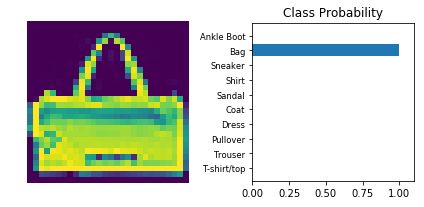

In [24]:
# Get our data
images, labels = next(iter(trainloader))
#flatten images 1 , 784
img = images.view(images.shape[0], -1)

image = images[0].view(1, 784)

with torch.no_grad():
    logits = model.forward(image)
ps = F.softmax(logits, dim=1)
view_classify(image,ps,version="Fashion")

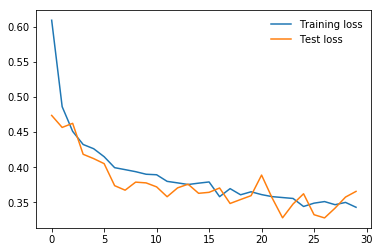

In [25]:
%matplotlib inline
%config InlineBacken.figure_format = "retina"
import matplotlib.pyplot as plt2

plt2.plot(train_losses, label="Training loss")
plt2.plot(test_losses, label="Test loss")
plt2.legend(frameon=False)